In [21]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm

import PLred.mapmodel as mm
import h5py
import json
import os

In [ ]:
specdir = '/mnt/datazpool/PL/yjkim/remapped/betcmi_20250211/'
n = 15

In [8]:
infofile = specdir + 'remapped_info.json'
info = json.load(open(infofile))

In [9]:
info

{'xmin': -24.299999999999997,
 'ymin': -24.299999999999997,
 'xmax': 24.299999999999997,
 'ymax': 24.299999999999997,
 'map_n': 15,
 'map_w': 3.0}

In [ ]:
specmap = np.zeros((info['map_n'], info['map_n'], 38, 200))
nframes = np.zeros((info['map_n'], info['map_n']), dtype=int)
psfmap = np.zeros((40, 40, 38, 200))
varmap = np.zeros((info['map_n'], info['map_n'], 38, 200))
normvarmap = np.zeros((info['map_n'], info['map_n'], 38, 200))

nbootstrap = 50
bootstraps = np.zeros((info['map_n'], info['map_n'], nbootstrap, 38, 200))

for i in range(info['map_n']):
    for j in range(info['map_n']):

        if os.path.exists(specdir + 'remapped_bin_%d_%d_spec.h5' % (i, j)):
            
            with h5py.File(specdir + 'remapped_bin_%d_%d_spec.h5' % (i, j), 'r') as f:

                spec = f['avgspec'][:]
                bootspecs = f['bootspecs'][:]


                # stdspec = np.nanstd(bootspecs, axis=0)
                nframe = f.attrs['num_frames']


            
            specmap[i, j, :, :] = spec
            nframes[i, j] = nframe
            bootstraps[i, j, :, :, :] = bootspecs
            # varmap[i, j, :, :] = var
            # normvarmap[i, j, :, :] = nomrvar

        else:
            specmap[i, j, :, :] = np.nan
            nframes[i, j] = 0
            bootstraps[i, j, :, :, :] = np.nan
            # varmap[i, j, :, :] = np.nan
            # normvarmap[i, j, :, :] = np.nan


        

In [24]:
np.shape(bootstraps)

(15, 15, 50, 38, 200)

In [29]:
var =  np.nanvar(bootstraps, axis=2)

/tmp/ipykernel_3963537/2078859705.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var =  np.nanvar(bootstraps, axis=2)


In [34]:
len(bootspecs)

50

In [45]:
bootstrap_normspecs = np.zeros_like(bootstraps)
for k in range(len(bootspecs)):
    bootstrap_normspecs[:,:,k] = bootstraps[:,:,k] / np.nansum(bootstraps[:,:,k], axis=(0,1))[None,None,:,:]

normvar = np.nanvar(bootstrap_normspecs, axis=2)
# var = np.nanvar(bootspecs, axis=0)
# nomrvar = np.nanvar(bootstrap_normspecs, axis=0)

/tmp/ipykernel_3963537/83663771.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice.
  normvar = np.nanvar(bootstrap_normspecs, axis=2)


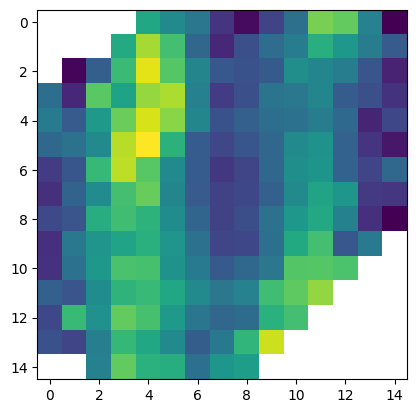

In [44]:
plt.imshow(bootstrap_normspecs[:,:,46,0,100])

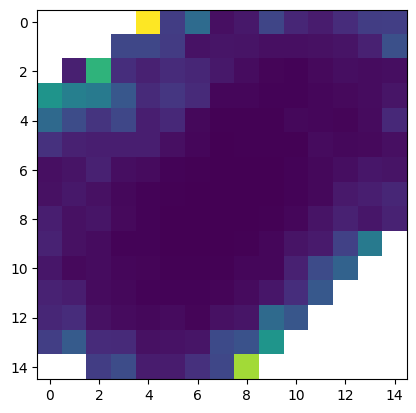

In [46]:
plt.imshow(normvar[:,:,0,100])

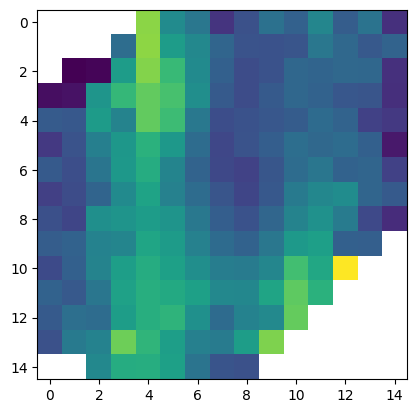

In [28]:
plt.imshow(bootstraps[:,:,0,3,100])

In [48]:
header = fits.Header()
header['XMIN'] = info['xmin']
header['XMAX'] = info['xmax']
header['YMIN'] = info['ymin']
header['YMAX'] = info['ymax']
header['MAP_N'] = info['map_n']
header['MAP_W'] = info['map_w']


hdu = fits.PrimaryHDU(specmap, header = header)
hdu2 = fits.ImageHDU(nframes, name = 'nframes')
hdu3 = fits.ImageHDU(psfmap, name='psfcam')
hdulist = fits.HDUList([hdu, hdu2, hdu3])


hdu4 = fits.ImageHDU(var, name='var')
hdu5 = fits.ImageHDU(normvar, name='normvar')
hdulist.append(hdu4)
hdulist.append(hdu5)

hdulist.writeto(specdir+'remapped_couplingmap.fits', overwrite=True)
print("Saved to "+specdir+'remapped_couplingmap.fits')

Saved to /mnt/datazpool/PL/yjkim/remapped/betcmi_20250211/remapped_couplingmap.fits


In [49]:
data = fits.open(specdir+'remapped_couplingmap.fits')

frames0 = data[0].data
header = data[0].header
numframes = data[1].data
var = data[3].data
normvar = data[4].data

In [50]:
pos_mas = np.linspace(header['XMIN'], header['XMAX'], header['MAP_N'])


In [51]:
normalized = frames0 / np.nansum(frames0, axis=(0,1))[None,None,:,:]


In [52]:
mapmodel = mm.CouplingMapModel(mapdata = specdir+'remapped_couplingmap.fits')


loading mapdata
masking data with less than 5 frames


In [53]:
wav_fitrange = np.r_[0:100, 120:200]
wav_reconrange = np.r_[0:200]
all_map_inputs, all_modeled_recons, all_modeled_coeffs, model_chi2 = \
    mapmodel.make_polynomial_model('corrected_betcmi_20250211_polymodel', wav_fitrange, wav_reconrange)


100%|██████████| 38/38 [00:09<00:00,  4.11it/s]


corrected_betcmi_20250211_polymodel.fits saved


MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailab

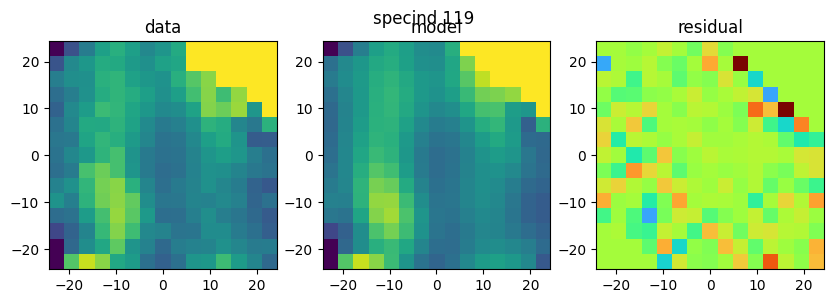

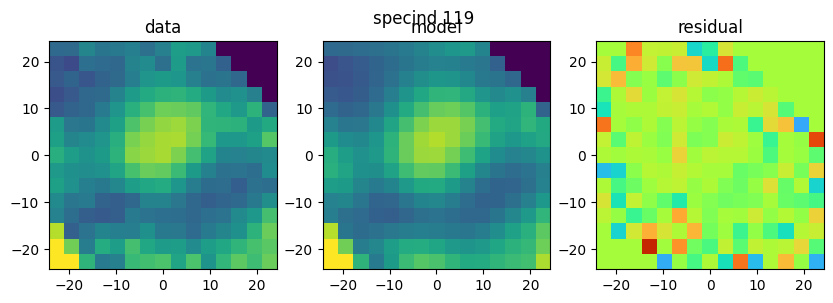

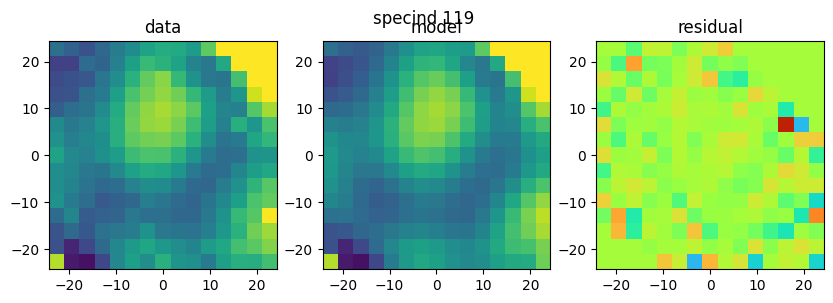

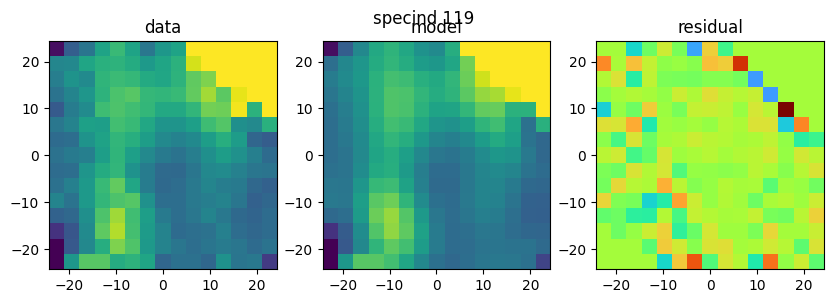

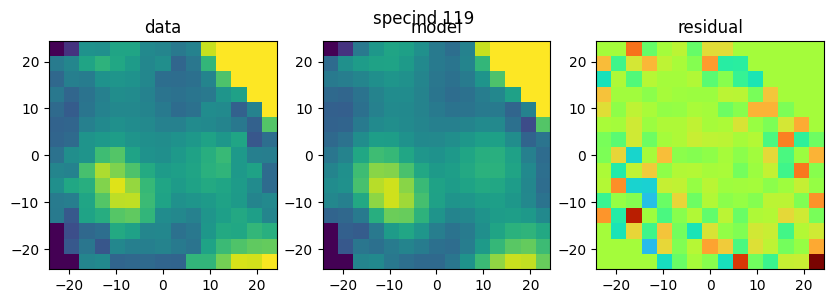

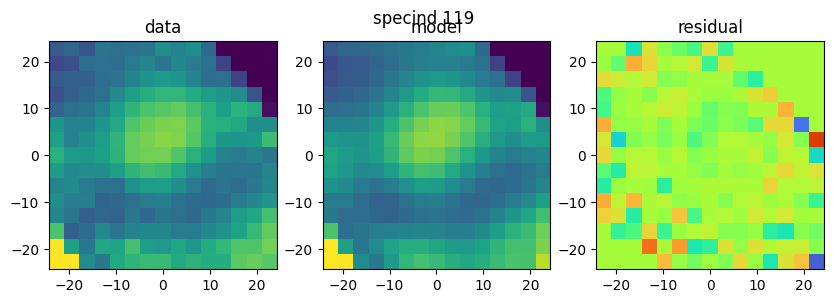

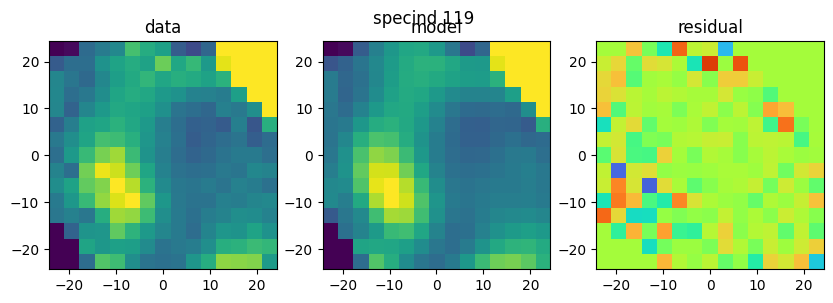

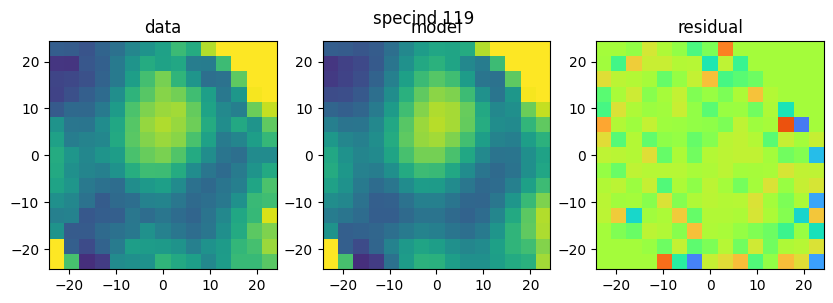

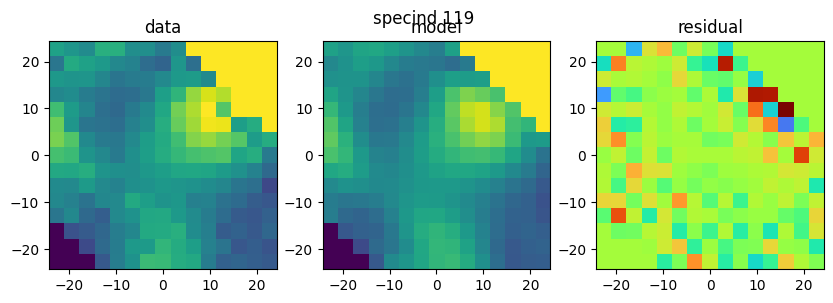

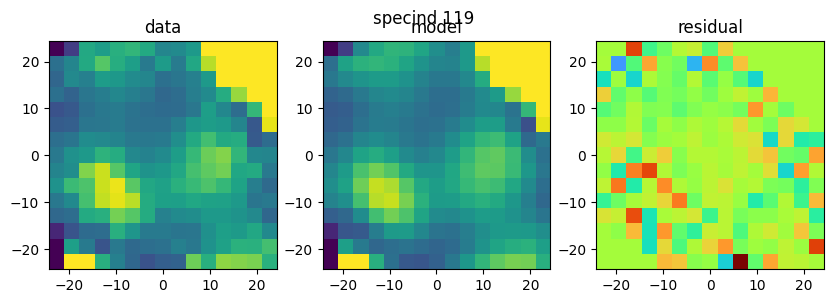

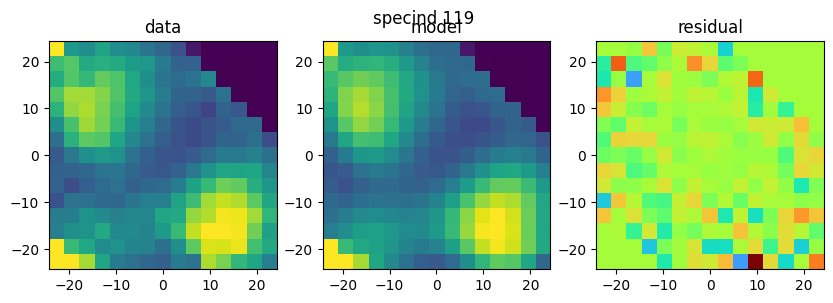

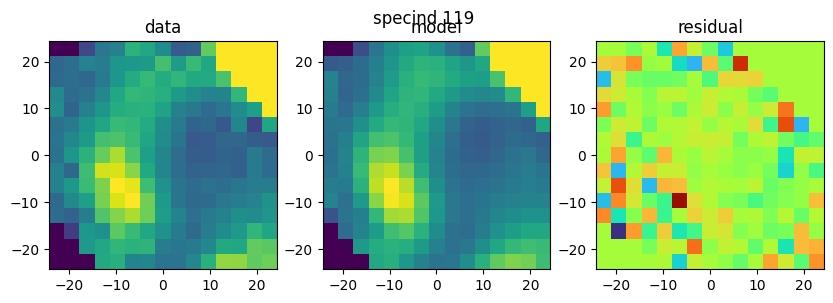

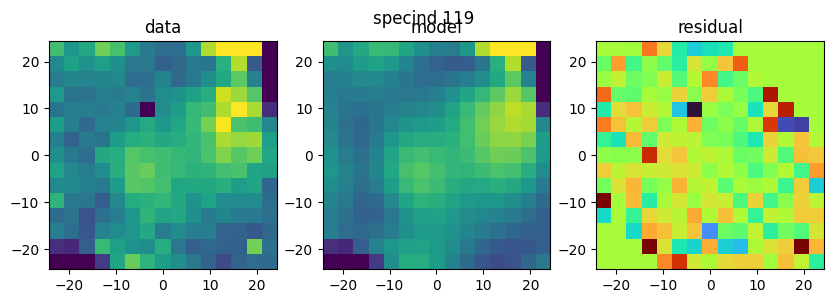

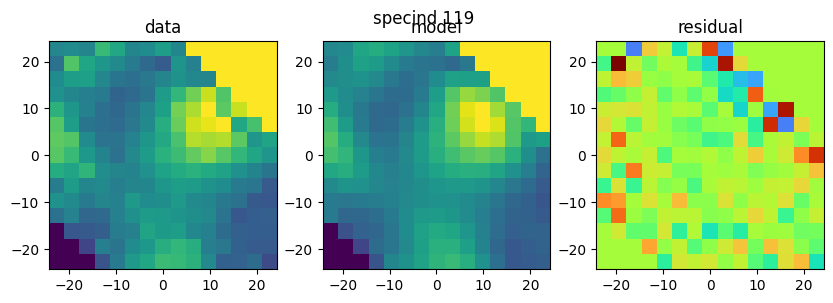

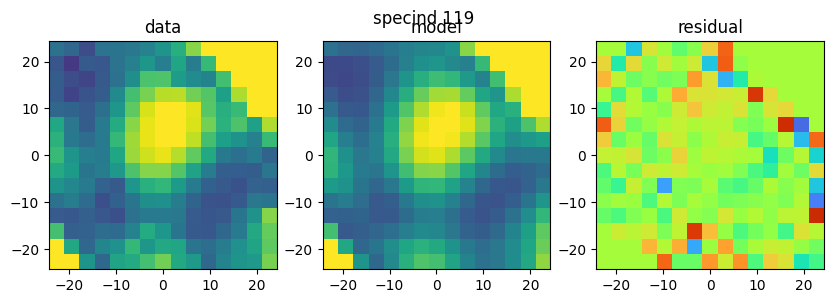

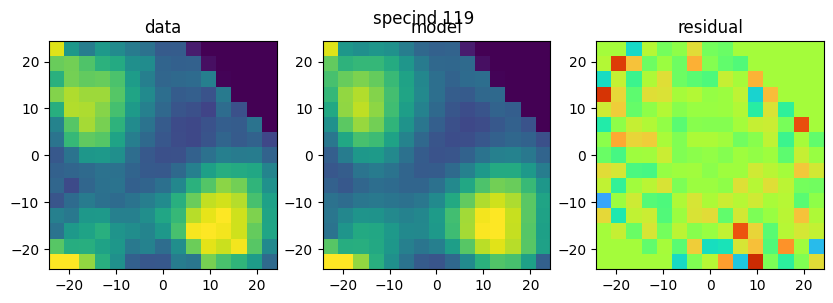

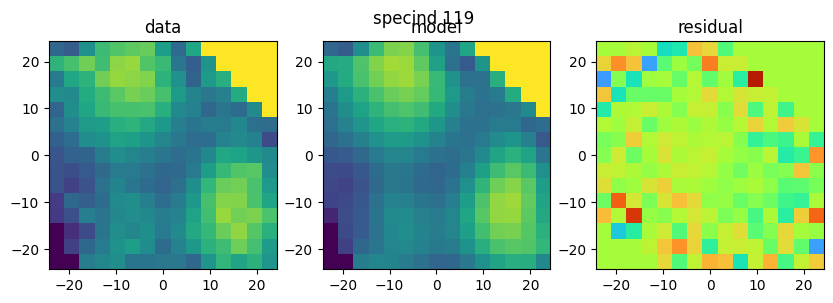

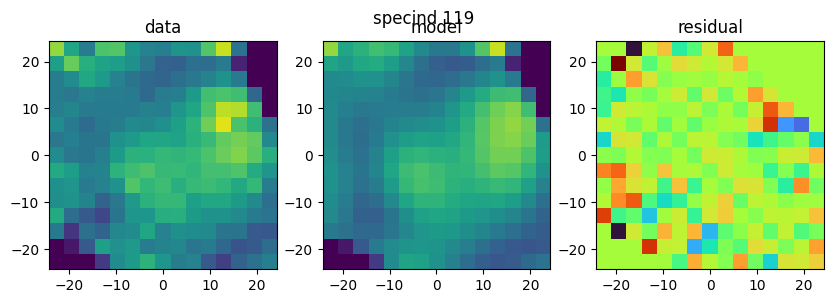

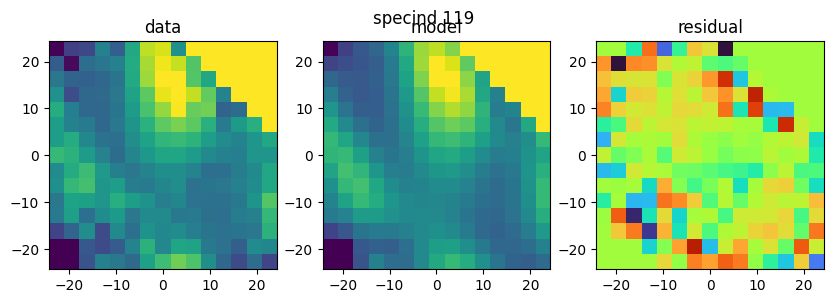

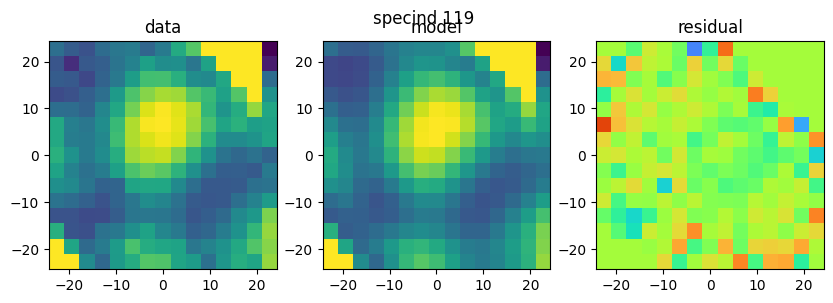

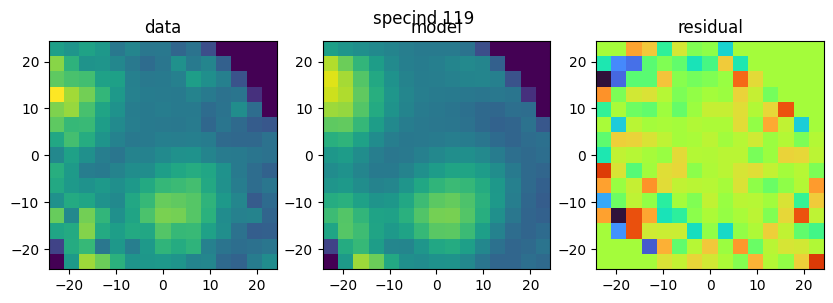

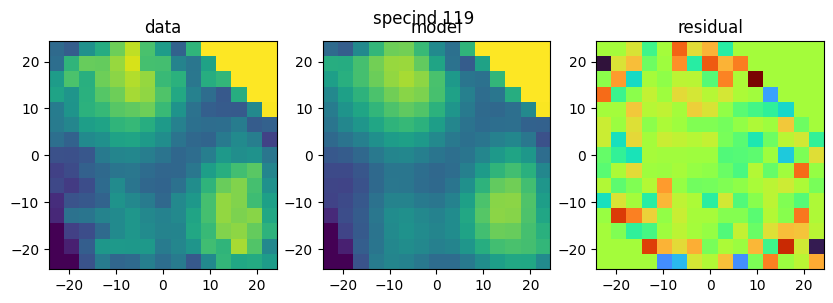

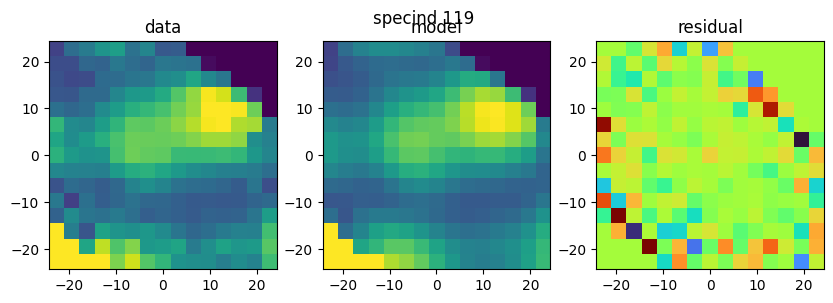

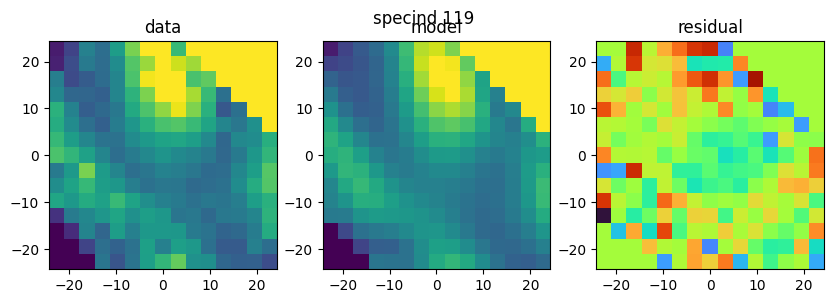

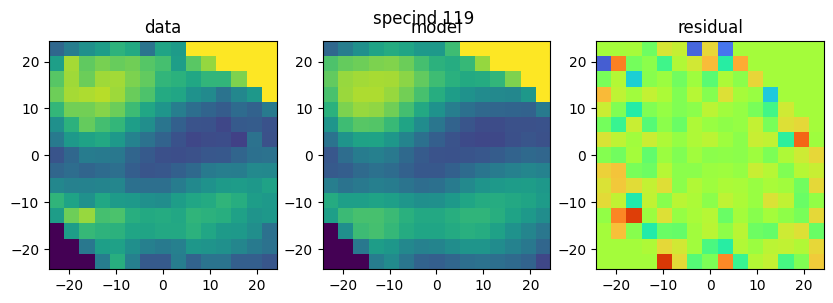

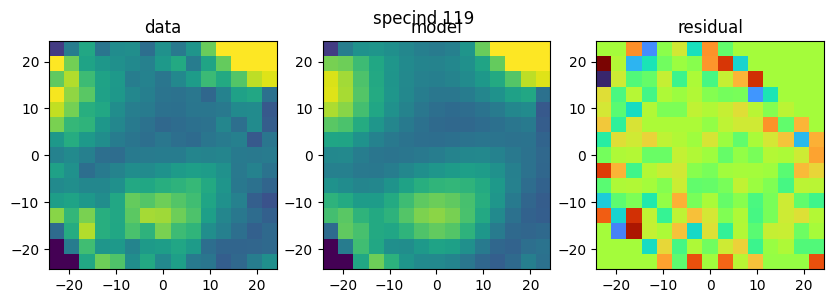

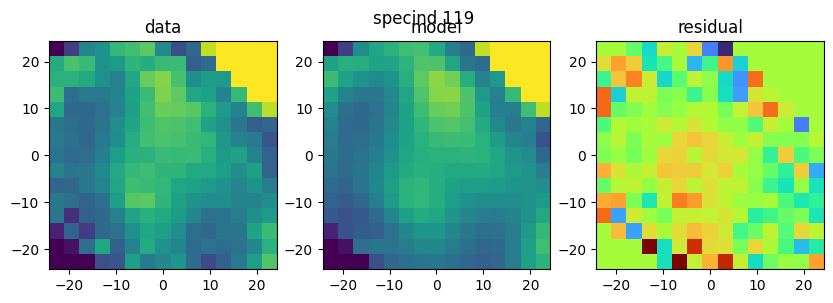

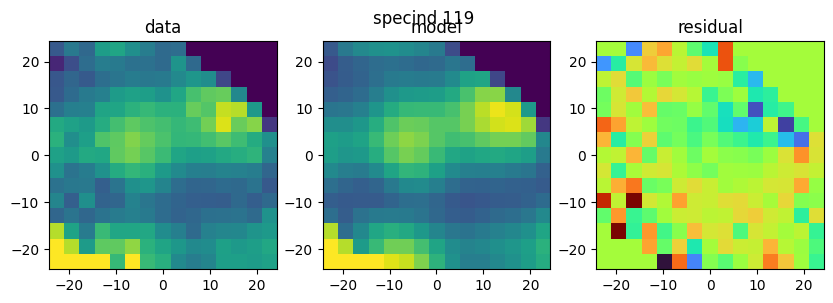

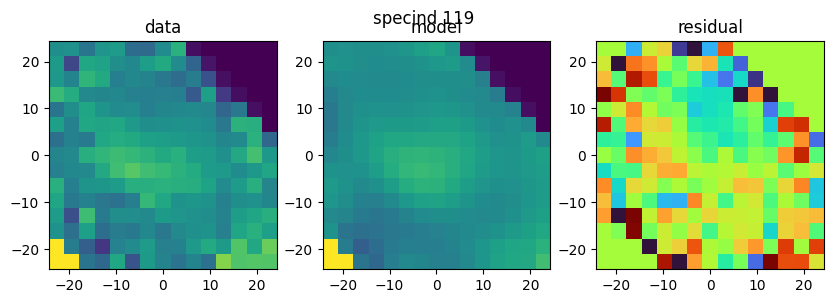

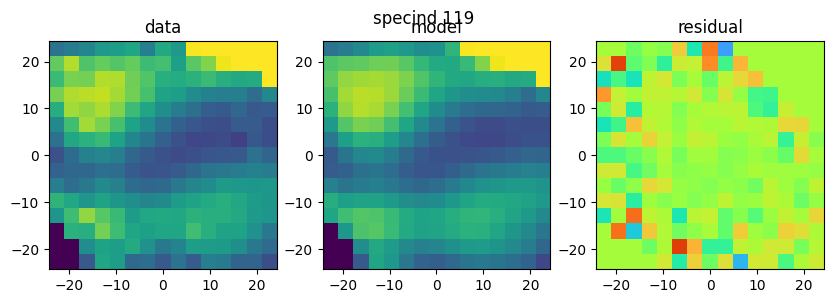

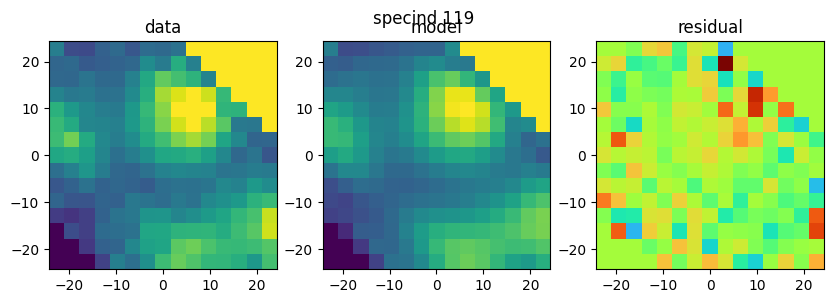

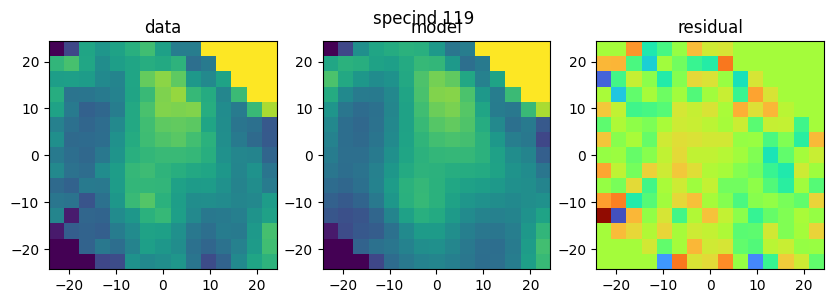

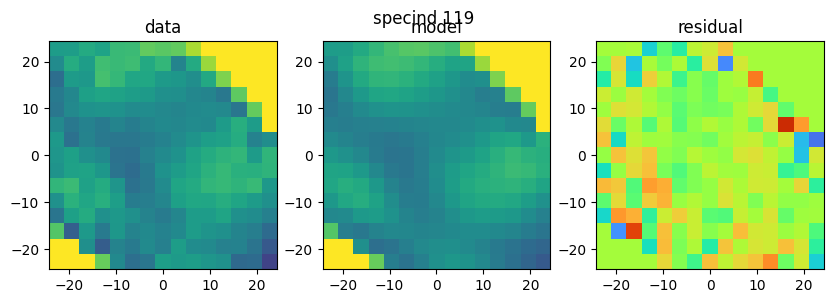

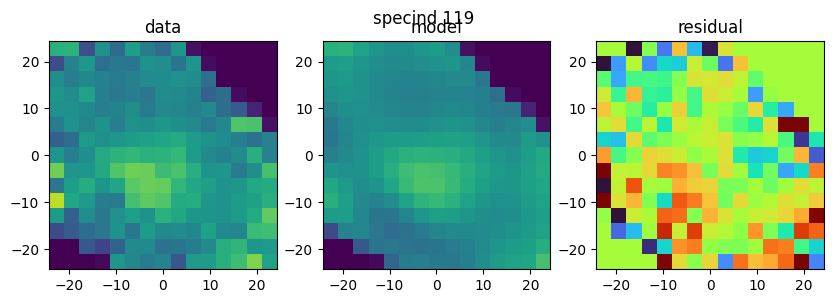

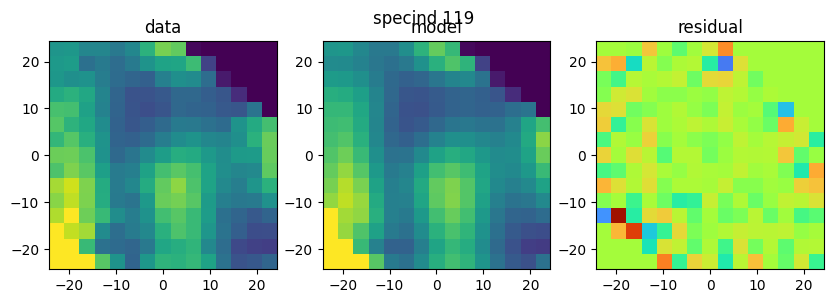

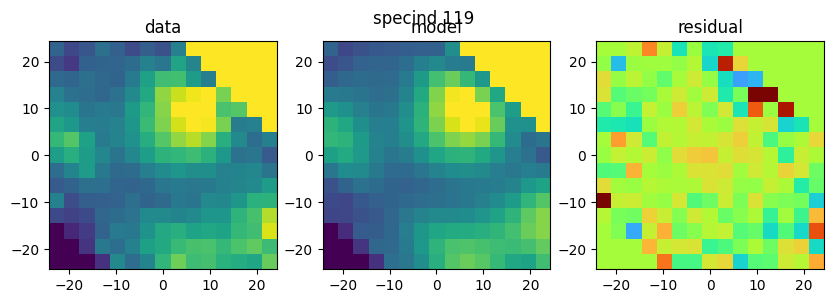

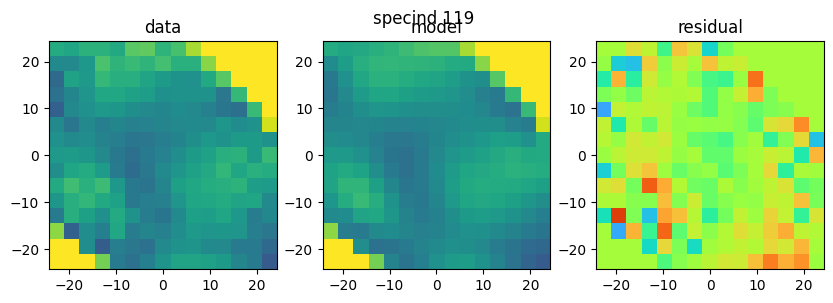

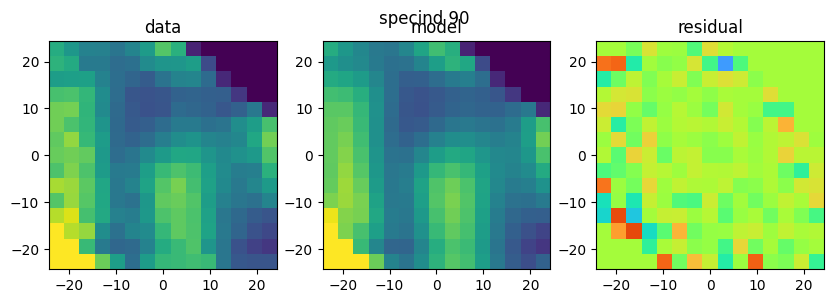

In [54]:
for fibind in range(38):
    fig, axs = plt.subplots(ncols=3, figsize=(10,3))

    def animate(specind):
        for ax in axs: ax.clear()
        axs[0].imshow(all_map_inputs[:,:,fibind,specind],vmin=0,vmax=0.01, origin='lower',
                    extent = (min(pos_mas), max(pos_mas), min(pos_mas), max(pos_mas)))
        axs[1].imshow(all_modeled_recons[:,:,fibind,specind],vmin=0,vmax=0.01, origin='lower',
                    extent = (min(pos_mas), max(pos_mas), min(pos_mas), max(pos_mas)))
        axs[2].imshow(all_map_inputs[:,:,fibind,specind] - all_modeled_recons[:,:,fibind,specind],vmin=-0.002,vmax=0.002,cmap='turbo',
                    origin='lower',
                    extent = (min(pos_mas), max(pos_mas), min(pos_mas), max(pos_mas)))
        # axs[3].imshow((all_map_input[specind]-modeled_recon[specind]),vmin=-0.001,vmax=0.001,cmap='RdBu')
        fig.suptitle('specind %d' % wav_reconrange[specind])

        axs[0].set_title('data')
        axs[1].set_title('model')
        axs[2].set_title('residual')

    anim = FuncAnimation(fig, animate,np.arange(90,120), interval = 100)
    anim.save('couplingmap_corrected_20250211_fibind%d.gif' % fibind)


In [55]:
np.shape(specmap)

(15, 15, 38, 200)

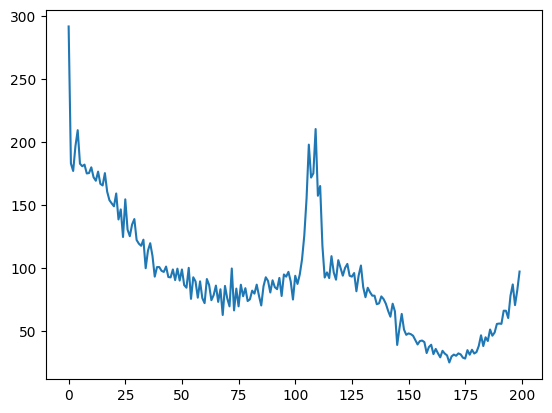

In [81]:
plt.plot(specmap[7,7,25,:])

In [6]:
np.shape(bootspecs)

(50, 38, 200)